In [19]:
#! /usr/bin/env python
%matplotlib inline
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import pylab
from astropy.table import Table
from dustmaps.planck import PlanckGNILCQuery

In [2]:
from dustmaps.config import config

In [3]:
config.fname

'/cargo/nhome/xingjian/.dustmapsrc'

In [4]:
!cat /cargo/nhome/xingjian/.dustmapsrc

{
  "data_dir": "/store/public/databases/dustmaps"
}

In [5]:
config['data_dir']

'/store/public/databases/dustmaps'

In [6]:
!ls /store/public/databases/dustmaps/planck/

COM_CompMap_Dust-GNILC-Model-Opacity_2048_R2.01.fits
HFI_CompMap_ThermalDustModel_2048_R1.20.fits


In [7]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, family='serif')    # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.rc('font', family='serif')    # controls default text sizes
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [3]:
# # import urllib.request
# # url = 'https://irsa.ipac.caltech.edu/data/Planck/release_1/all-sky-maps/maps/HFI_CompMap_ThermalDustModel_2048_R1.20.fits'  
# # urllib.request.urlretrieve(url,'HFI_CompMap_ThermalDustModel_2048_R1.20.fits')
# ebv = hp.read_map('HFI_CompMap_ThermalDustModel_2048_R1.20.fits',
#                   field=2)

In [4]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , 
                data , 
                np.vstack([x,y]).T , 
                method = "splinef2d", 
                bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, s=1, **kwargs )
    return ax


def get_densxyz(x, y, sort = True, bins = 20):
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = False )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , 
                data , 
                np.vstack([x,y]).T , 
                method = "splinef2d", 
                bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    return x, y, z

In [72]:
dustmap= hp.read_map('/store/public/databases/dustmaps/planck/COM_CompMap_Dust-GNILC-Model-Opacity_2048_R2.01.fits')

In [73]:
dustmap # 表示每个pixel的ebv

array([6.8553220e-07, 6.7645340e-07, 6.8380854e-07, ..., 9.0881935e-07,
       9.6175586e-07, 9.7573729e-07], dtype=float32)

The area per pix is 0.001 deg^2 and the highest density per pix is 13.504


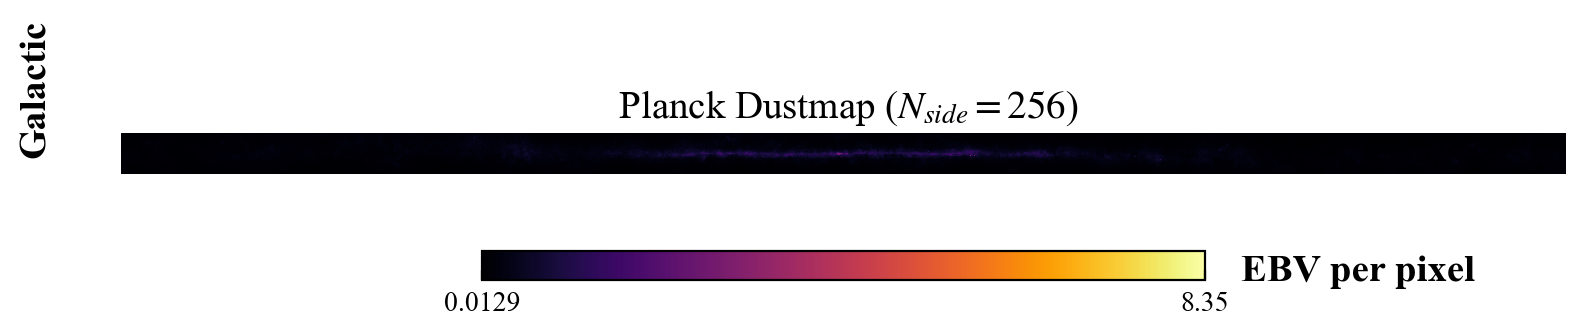

In [75]:
nside = 2048
npix = hp.nside2npix(nside)

hpxmap = dustmap

pi = np.pi
ssky = 4 * pi * ((180 / pi)**2)
spix = ssky / npix
sig_max = hptb.max() / (ssky / npix)
print('The area per pix is {0:.3f} deg^2 and the highest density per\
 pix is {1:.3f}'.format(spix, sig_max))


hpxmap = hpxmap/spix
hpxmap[hpxmap == 0] = 'nan'
# hpxmap[hpxmap <= 0] = hp.pixelfunc.UNSEEN
# hpxmap_sm = hp.smoothing(hpxmap,fwhm=np.radians(1))

cartb = hp.cartview(hpxmap,
                    coord=["G"],
                    # latra=[-20,20],
                    latra = [-5,5],  # 限制正负五度天区
                    cmap='inferno',
#             badcolor='w',
#             bgcolor='w',
                    unit="EBV per pixel",
                    xsize=1800, 
                    return_projected_map=True,
                   title=" Planck Dustmap ($N_{side}=256$)")


map_dump = pd.DataFrame(cartb)
map_dump.to_csv('planckdustmap_b5.csv',index=False)

In [76]:
cmdustmap = map_dump.values

In [38]:
# x1, y1, z1 = get_densxyz(newl.deg, df.b, sort=True, bins = [360,40])
# x2, y2, z2 = get_densxyz(newlg.deg, dfg.b, sort=True, bins = [360,40])

df_cmgpq = pd.read_csv('/cargo/public/catdata/gpq_nir/hpsm_GoodMockGPQNIR_b5_bootstrap.csv',index_col=False)
cmgpq = df_cmgpq.values
df_cmgal = pd.read_csv('/cargo/public/catdata/galaxy/hpsm_GoodMockGalNIR_b5.csv',index_col=False)
cmgal = df_cmgal.values

In [77]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='serif')    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.rc('font', family='serif')    # controls default text sizes
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

plt.rcParams["figure.figsize"] = (6,4) # 调整图片尺寸
plt.rcParams["figure.dpi"] = 200 # 提高图片分辨率

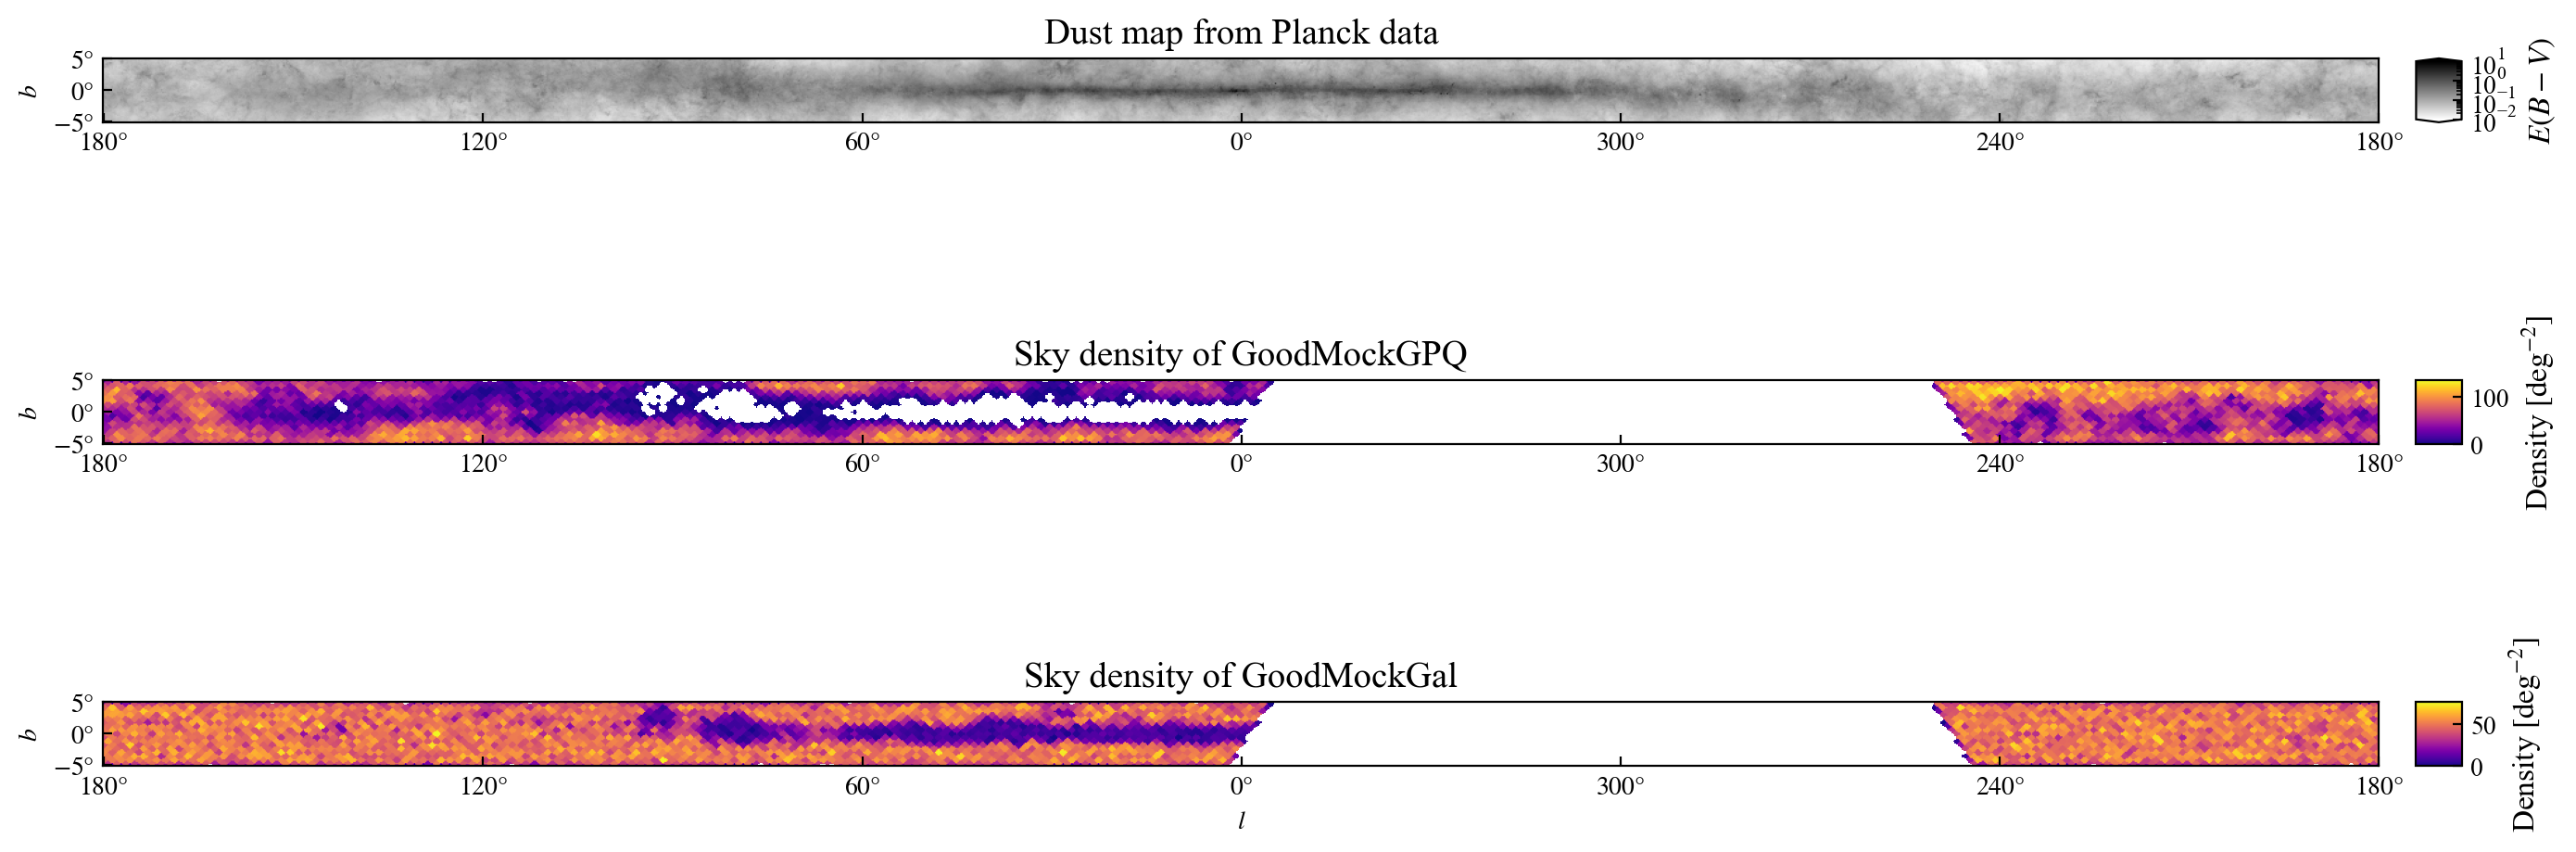

In [80]:
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14,6))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='2%', pad=0.2)
im = ax1.imshow(cmdustmap.data,origin='lower',
                cmap='binary',
                rasterized=True,
                norm=LogNorm(vmin=0.01, vmax=10))
ax1.set_xticks(np.arange(0, 1801, 300))
ax1.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                     r'$0\degree$',r'$300\degree$',r'$240\degree$',
                     r'$180\degree$'))
# ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 51, 25))
ax1.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax1.set_ylabel(r"$b$")
# ax1.grid(linestyle=':')
cbar1 = fig.colorbar(im, cax=cax, 
                     orientation='vertical',
                     extend='both',
                     label='$E(B-V)$')
cbar1.ax.yaxis.label.set_size(12)
ax1.title.set_text('Dust map from Planck data')



im2 = ax2.imshow(cmgpq.data,
                 origin='lower',
                 cmap='plasma',
                 rasterized=True,
                norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq))
               )
ax2.set_xticks(np.arange(0, 1801, 300))
ax2.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                     r'$0\degree$',r'$300\degree$',r'$240\degree$',
                     r'$180\degree$'))
ax2.set_yticks(np.arange(0, 51, 25))
ax2.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax2.set_ylabel(r"$b$")
# ax2.grid(linestyle=':')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='2%', pad=0.2)
cbar2 = fig.colorbar(im2, cax=cax, orientation='vertical', label='Density [$\mathrm{deg}^{-2}$]')
cbar2.ax.yaxis.label.set_size(12)

ax2.title.set_text("Sky density of GoodMockGPQ")





im3 = ax3.imshow(cmgal.data,
                 origin='lower',
                 cmap='plasma',
                 rasterized=True,
                norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgal))
                )

ax3.set_xticks(np.arange(0, 1801, 300))
ax3.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                     r'$0\degree$',r'$300\degree$',r'$240\degree$',
                     r'$180\degree$'))
ax3.set_yticks(np.arange(0, 51, 25))
ax3.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax3.set_xlabel(r"$l$")
ax3.set_ylabel(r"$b$")
# ax3.grid(linestyle=':')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='2%', pad=0.2)
cbar3 = fig.colorbar(im3, 
                     cax=cax, 
                     orientation='vertical', 
                     label='Density [$\mathrm{deg}^{-2}$]')
cbar3.ax.yaxis.label.set_size(12)
ax3.title.set_text("Sky density of GoodMockGal")
plt.tight_layout()
plt.savefig('plkebv_goodmockq&g.pdf',dpi=300)